# Descripción General del Proyecto

Como parte del equipo de análisis de datos de una empresa emergente dedicada a la venta de productos alimenticios, se asigna un proyecto en donde el objetivo principal es evaluar cómo los usuarios interactúan con la aplicación móvil de la empresa, en particular, cómo navegan a través del embudo de ventas y cómo responden a un cambio de tipografía en la interfaz. Esta investigación se divide en dos componentes clave:

---

## Objetivo del Proyecto

Analizar el comportamiento del usuario a lo largo del embudo de conversión y evaluar, mediante pruebas estadísticas, el impacto de una nueva tipografía implementada en la app, para determinar si dicho cambio afecta significativamente el flujo de conversión de los usuarios.

---

## Parte 1: Análisis del Embudo de Conversión

Este análisis tiene como propósito identificar cómo los usuarios avanzan por las distintas etapas del embudo hasta llegar a la compra, y en qué punto del proceso se detienen con mayor frecuencia. Se analizaron las siguientes métricas:

- Distribución de usuarios en cada etapa del embudo.
- Porcentaje de abandono entre pasos consecutivos.
- Tasa de conversión acumulada a lo largo del embudo.

---

## Parte 2: Evaluación Experimental (Test A/A/B)

Con el fin de determinar si un cambio de tipografía en la aplicación impacta el comportamiento del usuario, se ha diseñado un experimento A/A/B con la siguiente estructura:

- **Grupo 246 (Control A1)**: Tipografía original.
- **Grupo 247 (Control A2)**: Tipografía original.
- **Grupo 248 (Experimental B)**: Nueva tipografía.

### Etapas del análisis:
1. **Prueba A/A**: Comparar los grupos de control entre sí (246 vs 247) para verificar la validez del experimento y garantizar que no existen diferencias significativas previas.
2. **Prueba A/B**: Comparar los grupos de control con el grupo experimental (246 vs 248 y 247 vs 248) para evaluar si el cambio de tipografía tiene un impacto estadísticamente significativo en el comportamiento del usuario.

---

### Descripción de los Datos
Cada entrada de registro representa un evento de usuario con las siguientes columnas:
- **EventName**: Nombre del evento.
- **DeviceIDHash**: Identificador único del usuario.
- **EventTimestamp**: Hora del evento.
- **ExpId**: Número del experimento:
  - 246 y 247 → Grupos de control.
  - 248 → Grupo de prueba.

---

Este análisis permitirá tomar decisiones informadas sobre el diseño de la interfaz de la app, buscando mejorar la experiencia del usuario y optimizar el rendimiento del embudo de ventas.

  

# Cargar y visualizar los datos

In [57]:
# Importar las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [58]:
# Cargar datos
events = pd.read_csv('logs_exp_us.csv', sep = '\t')

In [59]:
# Visualizar las primeras filas
events.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [60]:
# Visualizar la información del dataframe
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


# Limpieza de datos

In [61]:
# Renombrar columnas
new_columns = {'EventName':'event', 'DeviceIDHash':'user_id', 'EventTimestamp':'datetime', 'ExpId':'group'}
events = events.rename(columns= new_columns)

In [62]:
# Convertir a tipo object las columnas con identificadores
events['user_id'] = events['user_id'].astype('object')
events['group'] = events['group'].astype('object')

In [63]:
# Convertir a tipo datetime la columna con la fecha del evento
events['datetime'] = pd.to_datetime(events['datetime'], unit= 's')

In [64]:
# Revisar duplicados
events.duplicated().sum()

np.int64(413)

In [65]:
# Eliminar duplicados
events = events.drop_duplicates()

In [66]:
# Revisar si hay valores nulos
events.isna().sum()

event       0
user_id     0
datetime    0
group       0
dtype: int64

In [67]:
# Verificar posibles errores de escritura en la columna 'event'
events['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [68]:
# Revisar que solo existan los grupos mencionados
events['group'].unique()

array([246, 248, 247], dtype=object)

# Exploración de los datos

## ¿Cuántos eventos hay en los registros?

In [69]:
print(f'Total de eventos únicos: {events['event'].nunique()}')
print(f'Total de eventos registrados: {events['event'].count()}')

Total de eventos únicos: 5
Total de eventos registrados: 243713


## ¿Cuántos usuarios hay en los registros?

In [70]:
print(f'Total de usuarios registrados: {events['user_id'].nunique()}')

Total de usuarios registrados: 7551


## ¿Cuál es el promedio de eventos por usuario?

In [71]:
# agrupar por usuarios y contar los eventos para obtener el promedio
events_per_user_avg = events.groupby('user_id').agg({'event':'count'}).reset_index()
print(f'Promedio de eventos por usuario: {events_per_user_avg['event'].mean():.2f}')

Promedio de eventos por usuario: 32.28


## Revisar el periodo de tiempo que cubren los datos

In [72]:
print(f'Los eventos están entre: {events['datetime'].min()} y {events['datetime'].max()}')

Los eventos están entre: 2019-07-25 04:43:36 y 2019-08-07 21:15:17


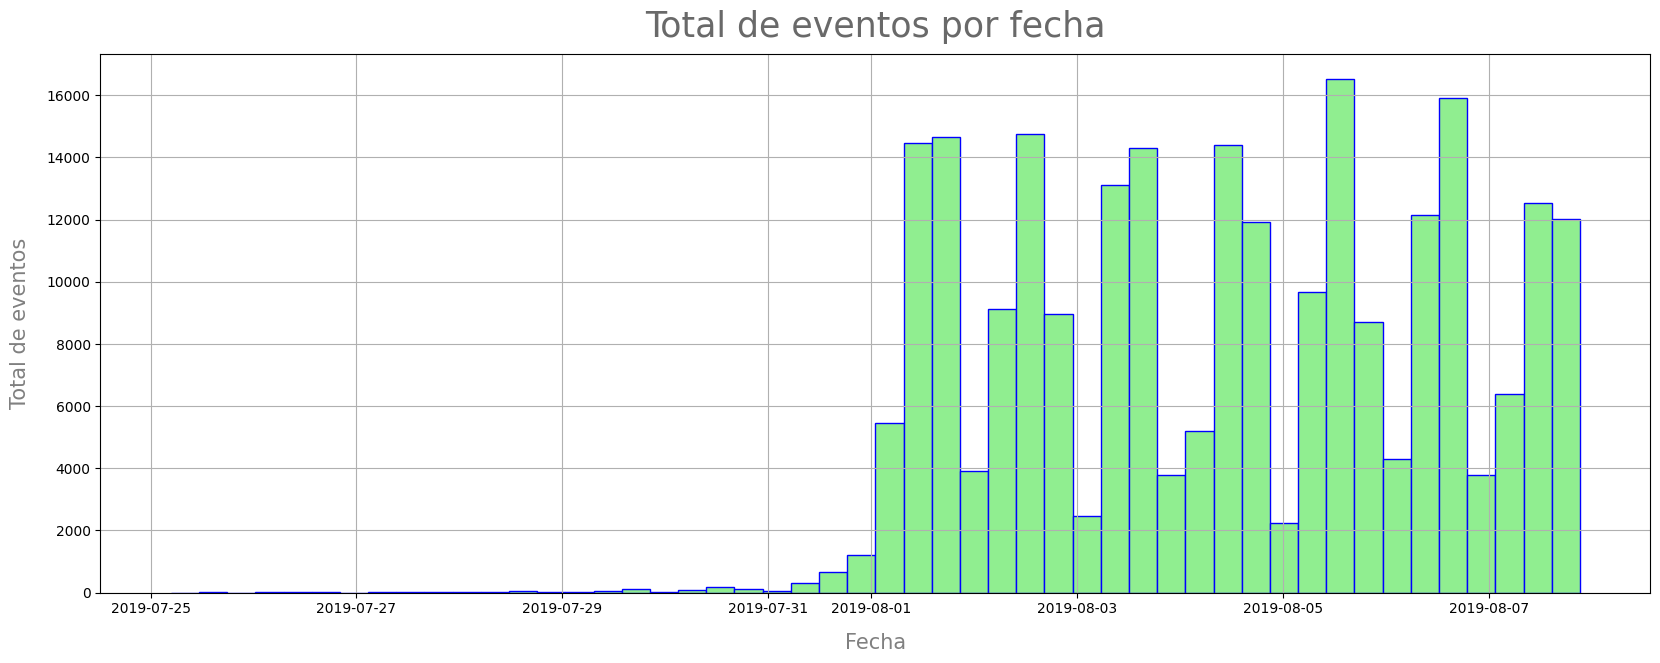

In [73]:
# Trazar un histograma de los eventos por fecha y verificar que sean considerables para el análisis
plt.figure(figsize= (20,7))
plt.hist(events['datetime'], bins= 50, color = 'lightgreen', edgecolor = 'b')
plt.title('Total de eventos por fecha', fontsize = 25, pad= 12, color = 'dimgray')
plt.xlabel('Fecha', fontsize = 15, labelpad= 12, color = 'gray')
plt.ylabel('Total de eventos', fontsize = 15, labelpad= 12, color = 'gray')
plt.grid(True)
plt.show()

### Observaciones
El análisis preliminar del número de eventos registrados por fecha reveló una actividad considerablemente baja entre el 25 y el 31 de julio. Dado que este periodo presenta un volumen atípicamente reducido de interacciones, se ha decidido restringir el análisis a un intervalo temporal más representativo, excluyendo dichas fechas para asegurar la validez y consistencia de los resultados.

In [74]:
# Realizar filtro
events_filtered = (events[events['datetime'] >= '2019-08-01']).copy()

In [75]:
# Revisar el nuevo tamaño del datafrmae
events_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240887 entries, 2828 to 244125
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     240887 non-null  object        
 1   user_id   240887 non-null  object        
 2   datetime  240887 non-null  datetime64[ns]
 3   group     240887 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 9.2+ MB


## Revisar la importancia de los usuarios perdidos

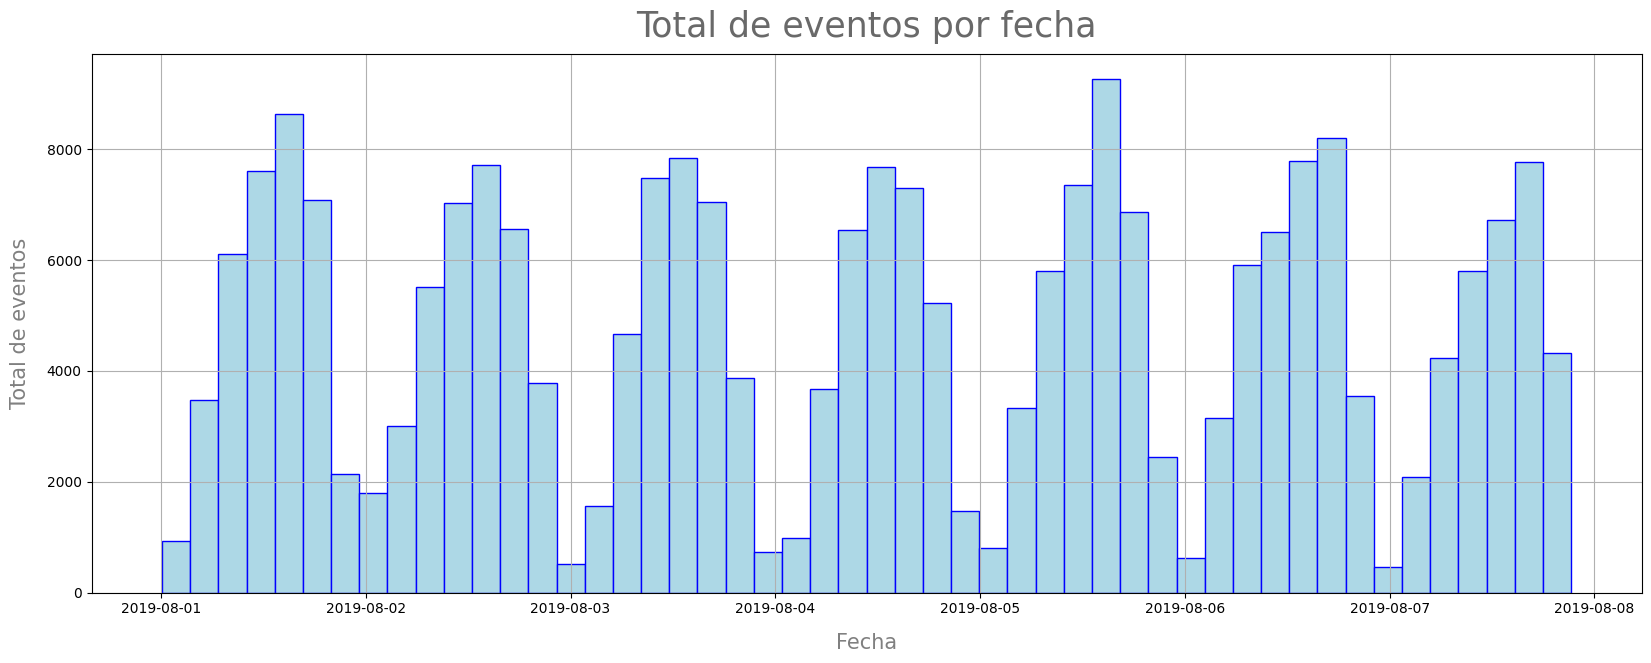

In [76]:
# Realizar un histograma de los eventos con los datos filtrados
plt.figure(figsize= (20,7))
plt.hist(events_filtered['datetime'], bins= 50, color = 'lightblue', edgecolor = 'b')
plt.title('Total de eventos por fecha', fontsize = 25, pad= 12, color = 'dimgray')
plt.xlabel('Fecha', fontsize = 15, labelpad= 12, color = 'gray')
plt.ylabel('Total de eventos', fontsize = 15, labelpad= 12, color = 'gray')
plt.grid(True)
plt.show()

### Observaciones
Se aprecia una distribución más clara de los datos, con una tendencia marcada de variaciones a lo largo del día, donde se alternan periodos de mayor y menor actividad. Esta dinámica sugiere un patrón de comportamiento típico del usuario, con picos y descensos que podrían estar relacionados con horarios específicos o rutinas diarias.

In [77]:
# Revisar el número de usuarios perdidos
total_users_before = events['user_id'].nunique()
total_users_after = events_filtered['user_id'].nunique()
lost_users = total_users_before - total_users_after

In [78]:
print(f'Total de usuarios antes del filtro: {total_users_before}')
print(f'Total de usuarios despues del filtro: {total_users_after}')
print(f'Total de usuarios perdidos: {lost_users}')

Total de usuarios antes del filtro: 7551
Total de usuarios despues del filtro: 7534
Total de usuarios perdidos: 17


In [79]:
# Revisar el número de usuarios por grupo
users_per_group_before = events.groupby('group').agg({'user_id':'nunique'}).reset_index()
users_per_group_after = events_filtered.groupby('group').agg({'user_id':'nunique'}).reset_index()

In [80]:
print(f'Total de usuarios por grupo antes del filtro: \n {users_per_group_before}\n')
print(f'Total de usuarios por grupo despues del filtro: \n {users_per_group_after}')

Total de usuarios por grupo antes del filtro: 
    group  user_id
0    246     2489
1    247     2520
2    248     2542

Total de usuarios por grupo despues del filtro: 
    group  user_id
0    246     2484
1    247     2513
2    248     2537


In [81]:
# Calcular el porcentaje que representan los usuarios perdidos
print(f'Porcentaje de usuarios perdidos: {((lost_users/total_users_before) * 100):.2f}%')

Porcentaje de usuarios perdidos: 0.23%


### Observaciones

Después de aplicar el filtro de fechas, se detectó una pérdida de 17 usuarios, repartidos entre los tres grupos del experimento. Aun así, esta pérdida representa solo el 0.23 % del total de usuarios, por lo que no se considera una reducción significativa.

Lo positivo es que, gracias a este filtrado, se logró acortar el periodo de análisis a un rango más claro y mejor distribuido, como se puede apreciar en el grafico, sin afectar la calidad de los datos.

# Estudiar el embudo de ventas

In [82]:
# Visualizar los eventos registrados
print(f'Eventos regitrados: \n {events_filtered['event'].unique()}')

Eventos regitrados: 
 ['Tutorial' 'MainScreenAppear' 'OffersScreenAppear' 'CartScreenAppear'
 'PaymentScreenSuccessful']


In [83]:
# Cálcular la frecuencia de los eventos
frequency_per_event = events_filtered['event'].value_counts().reset_index().rename(columns= {'count': 'frequency'})

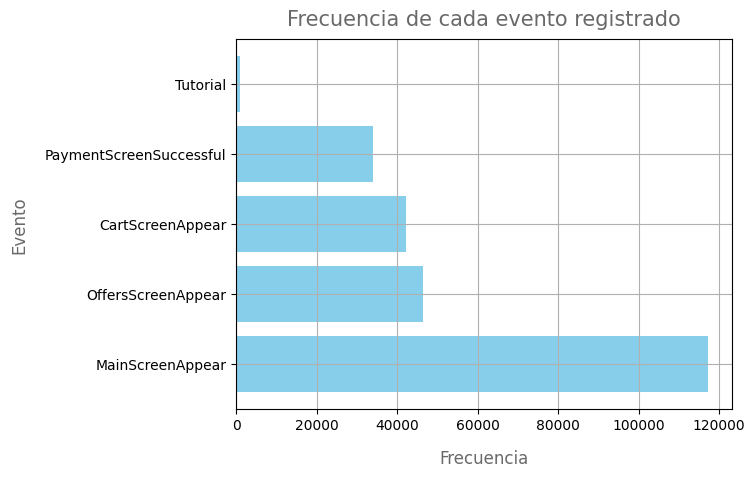

In [84]:
# Gráfico de barras para visualizar la frecuencia de cada evento
plt.barh(frequency_per_event['event'], frequency_per_event['frequency'], color = 'skyblue')
plt.title('Frecuencia de cada evento registrado', pad = 10, fontsize = 15, color = 'dimgray')
plt.ylabel('Evento', fontsize = 12, labelpad = 12, color = 'dimgrey')
plt.xlabel('Frecuencia', fontsize = 12, labelpad= 12, color = 'dimgray')
plt.grid(True)
plt.show()

In [85]:
# Calcular el numero de usuarios que realizaron cada evento al menos una vez
users_per_event = events_filtered.groupby('event').agg({'user_id':'nunique'}).reset_index().sort_values(by= 'user_id', ascending = False)

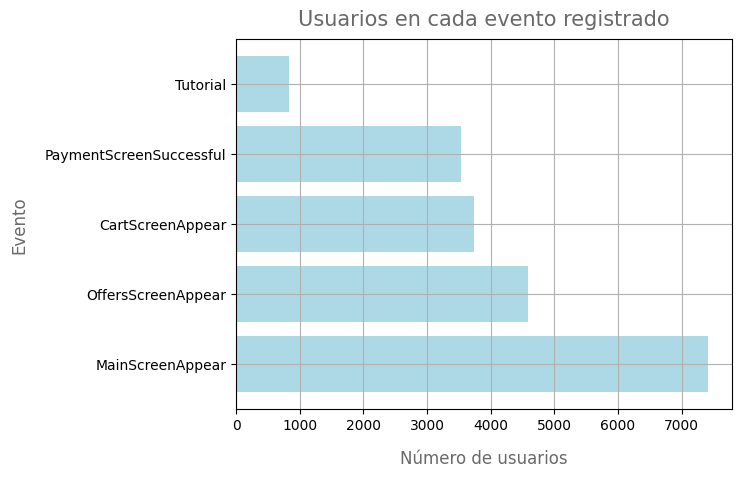

In [86]:
# Gráfico de barras para visualizar la frecuencia de cada evento
plt.barh(users_per_event['event'], users_per_event['user_id'], color = 'lightblue')
plt.title('Usuarios en cada evento registrado', pad = 10, fontsize = 15, color = 'dimgray')
plt.ylabel('Evento', fontsize = 12, labelpad = 12, color = 'dimgrey')
plt.xlabel('Número de usuarios', fontsize = 12, labelpad= 12, color = 'dimgray')
plt.grid(True)
plt.show()

## Definición del embudo de ventas

Después de calcular la frecuencia y el número de usuarios que realizaron cada evento registrado, fue posible identificar con mayor claridad cómo se estructura el recorrido típico del usuario dentro de la aplicación. Con base en los datos, se propone la siguiente secuencia como estructura inicial del embudo de eventos:

- Tutorial (omitible)  
- Main screen  
- Offers screen  
- Cart screen  
- Payment screen  

El recorrido comienza, en algunos casos, con la pantalla del tutorial. Sin embargo, esta sección puede ser omitida, permitiendo a los usuarios avanzar directamente a la pantalla principal. Desde ahí, lo más común es que el usuario se dirija a la pantalla de ofertas para seleccionar productos, luego acceda al carrito para revisar su pedido, y finalmente llegue a la pantalla de pago para completar la compra.

Los datos muestran que el tutorial es la etapa donde se pierde la mayor cantidad de usuarios. Esto se debe principalmente a que es una sección opcional, lo que genera una distorsión significativa en la proporción de usuarios que avanzan a las siguientes etapas. Por esta razón, se decidió excluir el tutorial del embudo de ventas para lograr una visualización más precisa del flujo real de los usuarios.

Así, el embudo de ventas definitivo queda definido de la siguiente forma:

- Main screen  
- Offers screen  
- Cart screen  
- Payment screen


In [87]:
# Realizar el segundo filtro para excluir el tutorial
events_funnel = events_filtered[events_filtered['event'] != 'Tutorial']

In [88]:
# Revisar el total de usuarios antes del segundo filtro
events_filtered.groupby('group')['user_id'].nunique()

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

In [89]:
# Revisar el total de usuarios despues del segundo filtro
events_funnel.groupby('group')['user_id'].nunique()

group
246    2483
247    2512
248    2535
Name: user_id, dtype: int64

Después de aplicar un segundo filtro se observó una disminución de únicamente 4 usuarios. Esta pérdida es mínima y no representa un impacto significativo en los resultados del análisis.

In [90]:
# Calcular el total de usuarios por etapas en el embudo
funnel = events_funnel.groupby('event').agg({'user_id':'nunique'}).reset_index().sort_values(by='user_id', ascending= False).rename(columns= {'user_id': 'total_users'})

## Calcular las tasas de retención y de abandono

In [91]:
# Calcular la tasa de retención acumulada
funnel['accum_retention_rate_%'] = round((funnel['total_users'] / funnel['total_users'].iloc[0]) * 100, 2)

In [92]:
# Calcular la tasa de retención por etapas
funnel['stage_retention_rate_%'] = round((funnel['total_users'] / funnel['total_users'].shift(1)) * 100, 2)

In [93]:
# Calcular la tasa de abandono en cada etapa del embudo
funnel['drop_off_rate_%'] = round(((funnel['total_users'].shift(1) - funnel['total_users']) / funnel['total_users'].shift(1)) * 100, 2)

In [94]:
# Visualizar resultados
funnel

,event,total_users,accum_retention_rate_%,stage_retention_rate_%,drop_off_rate_%
1,MainScreenAppear,7419,100.00,NaN,NaN
2,OffersScreenAppear,4593,61.91,61.91,38.09
0,CartScreenAppear,3734,50.33,81.30,18.70
3,PaymentScreenSuccessful,3539,47.70,94.78,5.22


### Gráficar las tasas de retención y de abandono

In [95]:
# Función para graficar las tasas de retención y abandono
def graph_rate(df, rate_name, title):
    plt.figure(figsize= (10,5))
    plt.barh(df['event'], df[rate_name], color = 'coral')    
    plt.title(title, pad = 10, fontsize = 15, color = 'dimgray')
    plt.ylabel('Etapa del embudo', fontsize = 12, labelpad = 12, color = 'dimgrey')
    plt.xlabel('Porcentaje de usuarios', fontsize = 12, labelpad= 12, color = 'dimgray')
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()

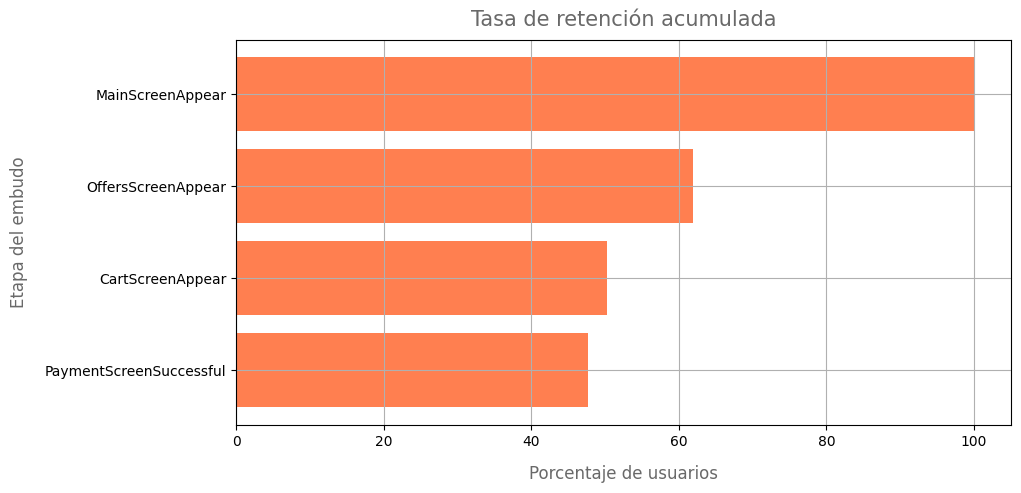

In [96]:
# Tasa de retención acumulada
graph_rate(funnel, 'accum_retention_rate_%', 'Tasa de retención acumulada')

### Interpretación
Según lo observado en el gráfico, la mayor pérdida de usuarios ocurre al pasar de la pantalla principal a la pantalla de ofertas. Aun así, aproximadamente la mitad de los usuarios que inician el recorrido llegan hasta la pantalla del carrito, y más del 45 % completan la compra. Estos resultados pueden considerarse positivos y sugieren un flujo general efectivo entre las distintas etapas del embudo.

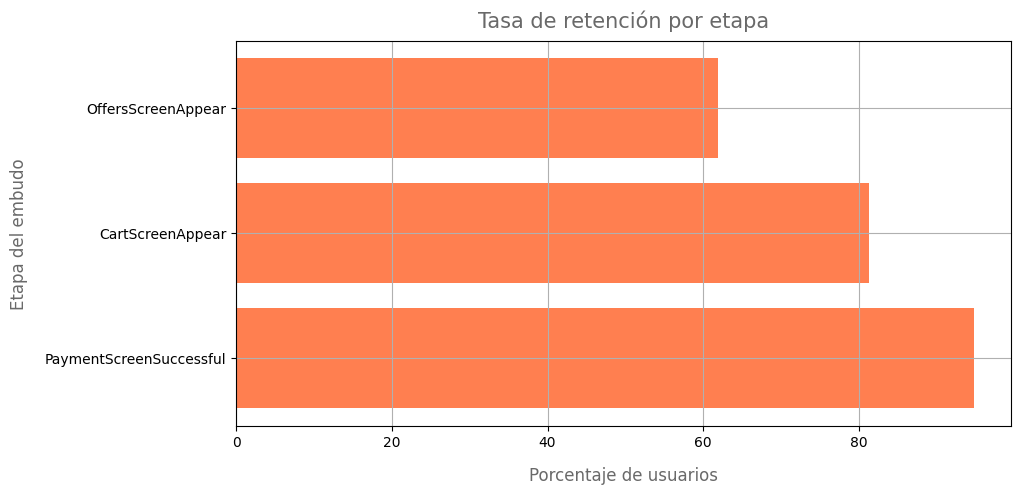

In [97]:
# Tasa de retención por etapa
graph_rate(funnel, 'stage_retention_rate_%', 'Tasa de retención por etapa')

### Interpretación
Observamos que la mayoría de los usuarios que avanzan desde la pantalla de ofertas hasta el carrito finalmente completan la compra. Es decir, una vez que un usuario llega a la pantalla de ofertas, tiene una alta probabilidad de concretar su compra.

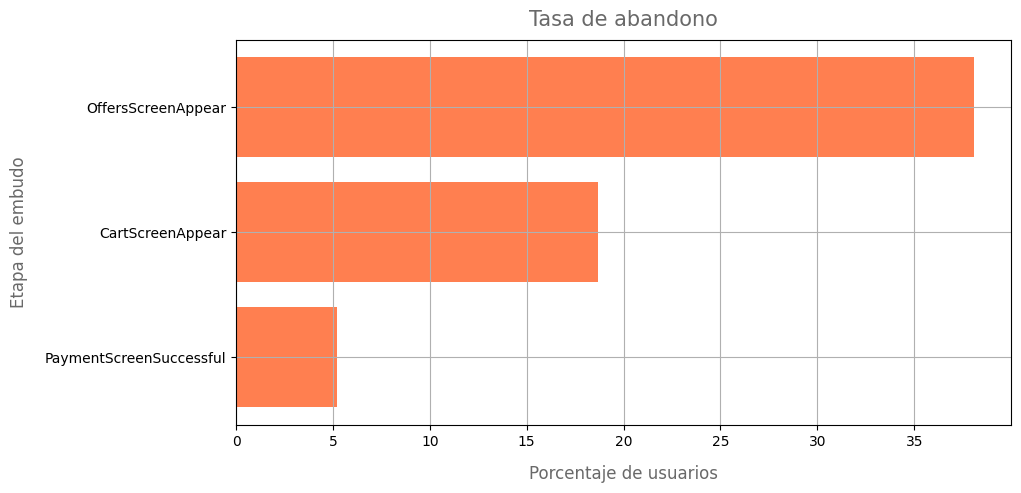

In [98]:
# Tasa de abandono
graph_rate(funnel, 'drop_off_rate_%', 'Tasa de abandono')

### Interpretación
Con este gráfico confirmamos que la etapa donde se produce el mayor abandono de usuarios es al pasar de la pantalla principal a la pantalla de ofertas. Sin embargo, una vez que los usuarios seleccionan productos en la pantalla de ofertas, tienen una alta probabilidad de completar la compra.

Este hallazgo plantea algunas preguntas importantes para profundizar en las posibles causas del abandono en esta etapa:

- ¿El diseño o la usabilidad de la pantalla de ofertas representa un obstáculo para los usuarios?

- ¿Son suficientemente atractivos y relevantes los productos o promociones presentados en la pantalla de ofertas?

- ¿Se comunica claramente el valor o beneficio de acceder a la pantalla de ofertas desde la pantalla principal?

- ¿La navegación hacia la pantalla de ofertas es intuitiva y accesible para todos los usuarios?

Resolver estas preguntas podrian ayudar a reducir considerablemente la tasa de abandono.

# Preparar los datos para las pruebas

In [99]:
# Crear un embudo por cada grupo
funnel_per_groups = events_funnel.groupby(['event', 'group'])['user_id'].nunique().unstack('group').reset_index()
funnel_per_groups = funnel_per_groups.rename(columns= {246:'users_group_246', 247:'users_group_247', 248:'users_group_248'}).sort_values(by = 'users_group_246', ascending= False) 
funnel_per_groups.columns.name = None

In [100]:
# Visualizar los datos obtenidos
funnel_per_groups

,event,users_group_246,users_group_247,users_group_248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


In [101]:
# Función para realizar la prueba
def test_proportions(df, group_1, group_2, event, alpha=0.05):
    # Usuarios que completaron el evento por grupo
    g1 = df[df['event'] == event][f'users_group_{group_1}'].iloc[0]
    g2 = df[df['event'] == event][f'users_group_{group_2}'].iloc[0]

    # Total de usuarios únicos por grupo en todo el embudo
    total_g1 = events_funnel[events_funnel['group'] == group_1]['user_id'].nunique()
    total_g2 = events_funnel[events_funnel['group'] == group_2]['user_id'].nunique()

    # Prueba Z
    count = [g1, g2]
    nobs = [total_g1, total_g2]
    stat, p_value = proportions_ztest(count, nobs)

    # Resultado booleano
    sig_dif = p_value < alpha

    # Devolver DataFrame con el resultado
    return pd.DataFrame({
        'event': [event],
        'group1': [group_1],
        'group2': [group_2],
        'p_value': [round(p_value, 4)],
        'sig_dif': [sig_dif]
    })

In [102]:
# Función para imprimir la prueba
def print_test(group1, group2):
    events_list = list(funnel_per_groups['event'])
    results = []

    for event in events_list:
        result = test_proportions(funnel_per_groups, group1, group2, event)
        results.append(result)

    results_test = pd.concat(results, ignore_index=True)
    
    return results_test

In [103]:
# Funcion para graficar el valor p
def graph_p_value(df, g1, g2): 
    plt.figure(figsize=(10,5))
    plt.bar(df['event'], df['p_value'], color='skyblue')
    plt.axhline(0.05, color='red', linestyle='--', label='α = 0.05')
    plt.title(f'P-Values por evento (Comparación Grupo {g1} vs {g2})')
    plt.ylabel('P-Value')
    plt.xlabel('Evento')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Definir hipotesis
- **``H0``** : No hay diferencia en la proporción del evento entre los dos grupos.
- **``H1``** : Sí hay una diferencia en la proporción del evento entre los dos grupos.

# Realizar prueba A/A

Se llevará a cabo una **prueba de proporciones (z-test)** entre los dos grupos de control ``(246 y 247)`` con el propósito de verificar si la división aleatoria de usuarios fue correcta.

La prueba se aplicará en cada etapa del embudo de ventas, comparando la proporción de usuarios que avanzan de una etapa a la siguiente en ambos grupos.

Si no se detectan diferencias estadísticamente significativas entre ellos, se podrá asumir que el experimento está bien balanceado y es confiable para evaluar el grupo experimental.

In [104]:
# Realizar prueba A/A
test_246_vs_247 = print_test(246, 247)

In [105]:
# Visualizar los resultados
test_246_vs_247

,event,group1,group2,p_value,sig_dif
0,MainScreenAppear,246,247,0.7527,False
1,OffersScreenAppear,246,247,0.2479,False
2,CartScreenAppear,246,247,0.2287,False
3,PaymentScreenSuccessful,246,247,0.1145,False


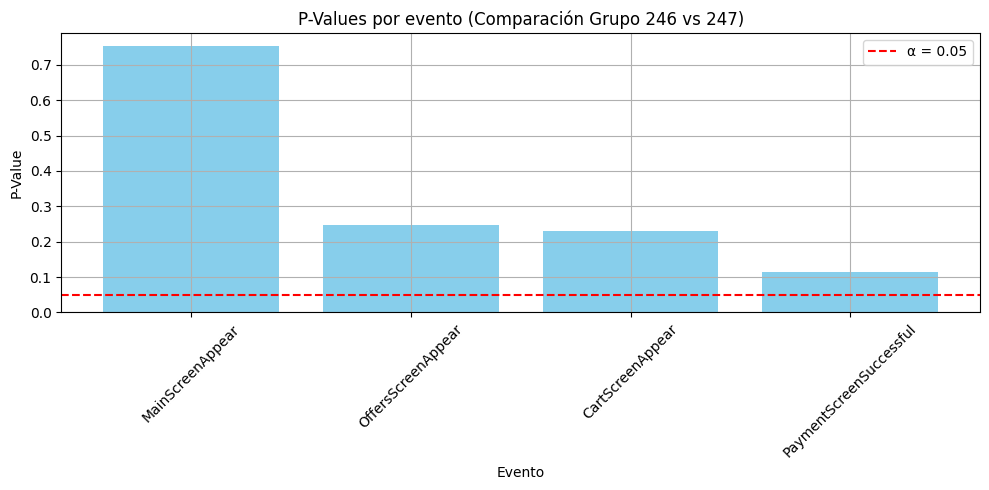

In [106]:
# Gráficar el valor p
graph_p_value(test_246_vs_247, 246, 247)

## Resultados del test A/A

Tras realizar las pruebas A/A entre los grupos de control, no se encontraron diferencias estadísticamente significativas en ninguno de los eventos analizados. Esto indica que los grupos están balanceados correctamente, lo que garantiza la confiabilidad de la comparación con el grupo experimental en fases posteriores del análisis.

# Realizar prueba A/B

Después de confirmar que los grupos de control **(246 y 247)** están correctamente balanceados y que es confiable utilizar el grupo experimental **248**, procedemos a realizar la prueba A/B.

En esta etapa, se comparará el grupo experimental 248 contra ambos grupos de control (246 y 247) para evaluar si la nueva tipografía implementada en la app tiene un impacto significativo en el comportamiento de los usuarios dentro del embudo.

## 246 vs 248

In [107]:
# Realizar prueba A/B
test_246_vs_248 = print_test(246, 248)

In [108]:
# Visualizar los resultados
test_246_vs_248

,event,group1,group2,p_value,sig_dif
0,MainScreenAppear,246,248,0.3387,False
1,OffersScreenAppear,246,248,0.2144,False
2,CartScreenAppear,246,248,0.0807,False
3,PaymentScreenSuccessful,246,248,0.2169,False


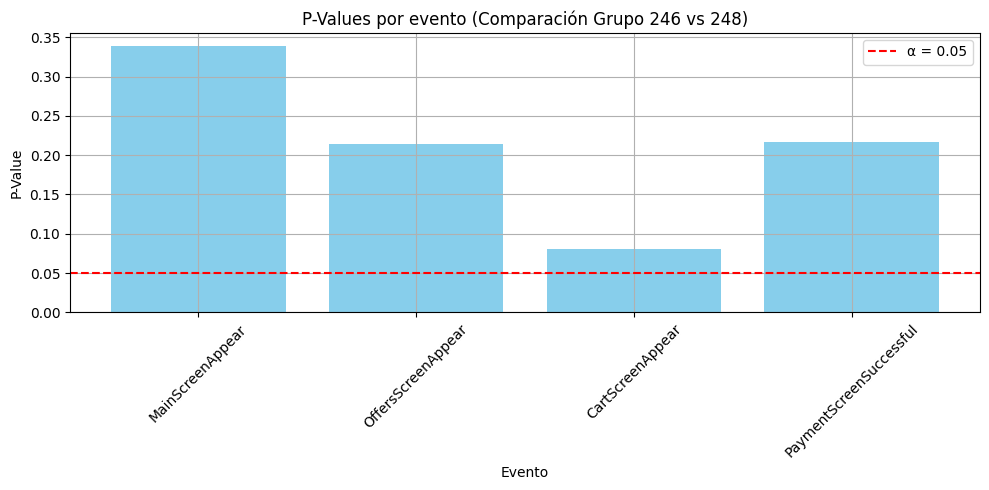

In [109]:
# Gráficar el valor p
graph_p_value(test_246_vs_248, 246, 248)

## 247 vs 248

In [110]:
# Realizar prueba A/B
test_247_vs_248 = print_test(247,248)

In [111]:
# Visualizar los resultados
test_247_vs_248

,event,group1,group2,p_value,sig_dif
0,MainScreenAppear,247,248,0.5195,False
1,OffersScreenAppear,247,248,0.9334,False
2,CartScreenAppear,247,248,0.5878,False
3,PaymentScreenSuccessful,247,248,0.7276,False


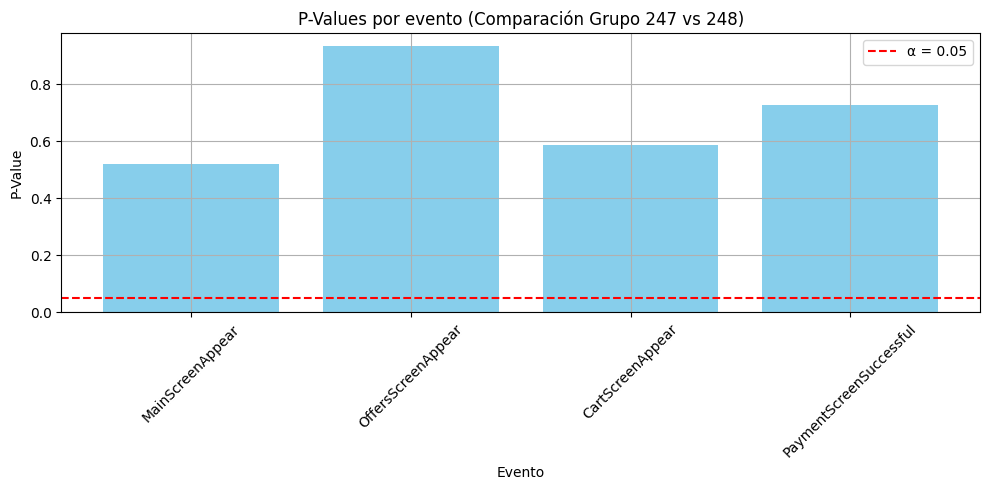

In [112]:
# Graficar el valor p
graph_p_value(test_247_vs_248, 247, 248)

## Resultados del test A/B

Tras realizar las pruebas estadísticas z-test de proporciones con un nivel de significancia de **α = 0.05**, se concluye que no existen diferencias estadísticamente significativas entre los grupos de control ``(246 y 247)`` y el grupo experimental ``(248)`` en ninguna de las etapas del embudo.

Esto indica que el cambio de tipografía en la aplicación no tuvo un impacto significativo en el comportamiento de los usuarios dentro del embudo de conversión. Por tanto, la modificación puede considerarse neutra en cuanto a su efecto en el flujo de navegación del usuario.

# 📌 Conclusiones del Proyecto

En este proyecto se analizó el comportamiento de los usuarios dentro de una aplicación dedicada a la venta de productos alimenticios, con el objetivo de evaluar el impacto de un cambio tipográfico sobre la conversión en el embudo de ventas.

## Principales hallazgos:

- Se procesaron más de **243,000 eventos** de **7,551 usuarios**, con un promedio de **32 eventos por usuario**.
- El flujo del embudo de conversión fue: **Main Screen → Offers Screen → Cart Screen → Payment Screen**.
- El mayor abandono ocurrió al pasar de la **pantalla principal a la de ofertas**, mientras que más del **45% de los usuarios que inician el proceso completan su compra**.
- Solo el **5% de los usuarios abandona después de agregar productos al carrito**, lo cual indica un embudo sólido a partir de la etapa de ofertas.

## Pruebas estadísticas:

Se aplicaron pruebas A/A y A/B para evaluar el impacto del cambio de tipografía en la conversión:

- **Prueba A/A**: No se encontraron diferencias significativas entre los grupos de control, validando la aleatorización.
- **Prueba A/B**: Tampoco se hallaron diferencias significativas entre los grupos control y el grupo experimental.

**Resultado**: el cambio tipográfico no tuvo un impacto estadísticamente significativo en el comportamiento de los usuarios. Se podria considerar una modificación neutra.

## Recomendación:

Dado que el mayor abandono ocurre en la transición hacia la pantalla de ofertas, se recomienda investigar más a fondo esta etapa mediante un nuevo test A/B centrado en:

- Contenido visual y atractivo de las ofertas.
- Mensajes persuasivos desde la pantalla principal.
- Optimización del tiempo de carga o usabilidad.